In [38]:
import matplotlib.pyplot as plt
import pandas as  pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, roc_curve, auc

In [39]:
base = pd.read_json('../data/orig_preds/base.json')
base_large = pd.read_json('../data/orig_preds/large_base.json')
ner = pd.read_json('../data/orig_preds/ner_mask.json')
ner_large = pd.read_json('../data/orig_preds/large_ner.json')
noise = pd.read_json('../data/orig_preds/noise.json')
noise_large = pd.read_json('../data/orig_preds/large_noise.json')
full_length = pd.read_json('../data/orig_preds/full_length.json')
final = pd.read_json('../data/orig_preds/backtranslation.json')
final_large = pd.read_json('../data/orig_preds/large_backtranslation.json')

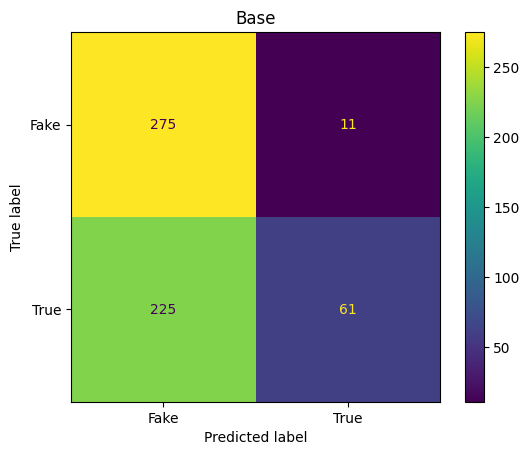

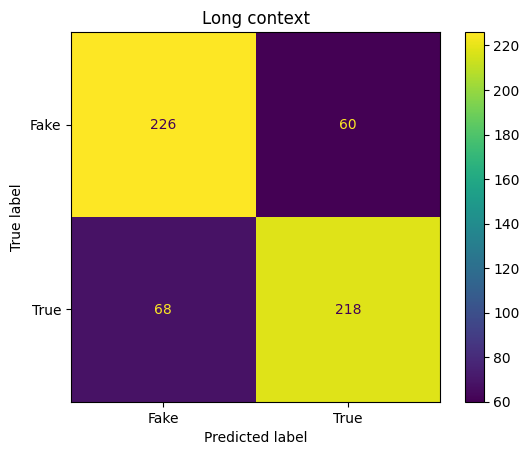

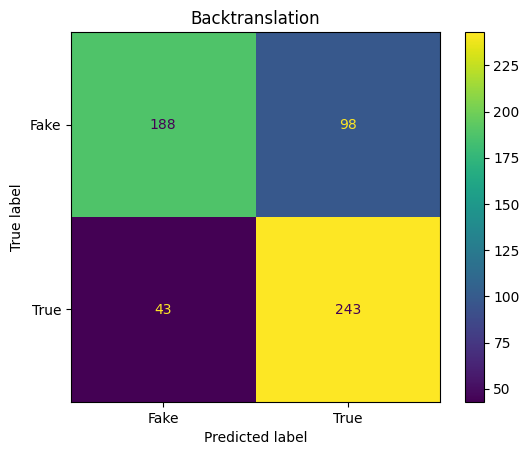

In [40]:
import sys
sys.path.append('..')
from utils import LABELS

models = [base, full_length, final]
nombres = ['Base', 'Long context', 'Backtranslation']

def get_confusion_matrix(df, name):
    cm = confusion_matrix(df['category'], df['predictions'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LABELS.keys())
    disp.plot()
    plt.title(name)
    plt.show()

for model, nombre in zip(models, nombres):
    get_confusion_matrix(model, nombre)

## Acierto

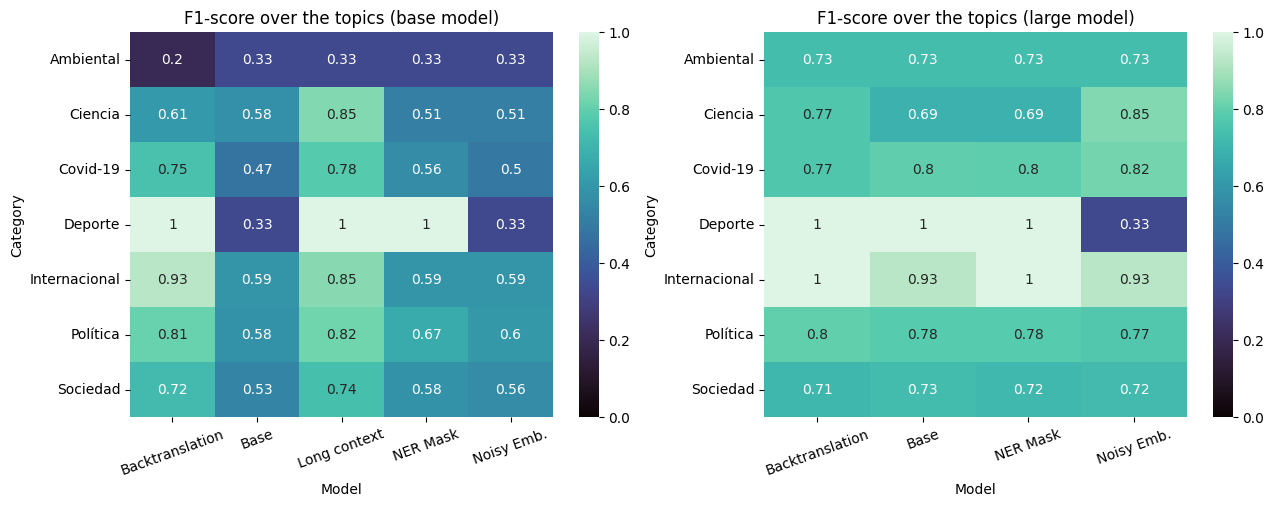

In [41]:
import seaborn as sns
from utils import LABELS

def get_report(data):
    report = {}
    for topic in data['topic'].unique():
        subset = data[data['topic'] == topic]
        report[topic] = classification_report(subset['category'].apply(lambda x: LABELS[x]), 
                                              subset['predictions'].apply(lambda x: LABELS[x]),
                                    labels=np.arange(2).tolist(),
                                    target_names=['Fake','True'],
                                    digits=4,
                                    zero_division=0,
                                    output_dict=True)
    return report


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
models = [base,full_length,ner,noise,final]
reports = [get_report(model) for model in models]
f1 = [[report[topic]['macro avg']['f1-score'] for topic in report.keys()] for report in reports]

nombres = ['Base']*len(f1[0]) + ['Long context']*len(f1[1]) + ['NER Mask']*len(f1[2]) + ['Noisy Emb.']*len(f1[3]) + ['Backtranslation']*len(f1[4])

data = pd.DataFrame({'Category': list(reports[0].keys())*len(reports),
                     'F1-score': [score for sublist in f1 for score in sublist],
                     'Model': nombres})
#sns.barplot(x='Category', y='F1-score', hue='Model', data=data)
sns.heatmap(data.pivot(index='Category',columns='Model',values='F1-score'), 
            annot=True, cmap='mako', # coolwarm
            vmin=0, vmax=1)
plt.xticks(rotation=20)
plt.title('F1-score over the topics (base model)')

plt.subplot(1,2,2)
models = [base_large, ner_large, noise_large, final_large]
reports = [get_report(model) for model in models]
f1 = [[report[topic]['macro avg']['f1-score'] for topic in report.keys()] for report in reports]

nombres = ['Base']*len(f1[0]) + ['NER Mask']*len(f1[1]) + ['Noisy Emb.']*len(f1[2]) + ['Backtranslation']*len(f1[3])

data = pd.DataFrame({'Category': list(reports[0].keys())*len(reports),
                        'F1-score': [score for sublist in f1 for score in sublist],
                        'Model': nombres})
#sns.barplot(x='Category', y='F1-score', hue='Model', data=data)
sns.heatmap(data.pivot(index='Category',columns='Model',values='F1-score'), 
            annot=True, cmap='mako', # coolwarm
            vmin=0, vmax=1)
plt.xticks(rotation=20)
plt.title('F1-score over the topics (large model)')

#plt.ylim(0.3,1.1)
plt.show()

F1-score over the topics
	Mean	Ponderated
Base: 0.4890 | 0.5203
Long context: 0.7677 | 0.7762
NER Mask: 0.6070 | 0.5906
Noisy Emb: 0.4898 | 0.5415
Backtranslation: 0.7169 | 0.7512

F1-score over the topics
	Mean	Ponderated
Base: 0.8088 | 0.7726
NER Mask: 0.8174 | 0.7710
Noisy Emb: 0.7372 | 0.7832
Backtranslation: 0.8266 | 0.7625



/tmp/ipykernel_17977/946880139.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data,pd.DataFrame({'Model': nombre, 'F1-score (%)': mean*100, 'Ponderation': 'Mean'}, index=[0])], ignore_index=True)
/tmp/ipykernel_17977/946880139.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data,pd.DataFrame({'Model': nombre, 'F1-score (%)': mean*100, 'Ponderation': 'Mean'}, index=[0])], ignore_index=True)
/tmp/ipykernel_17977/946880139.py:63: UserWarning: Boolean S

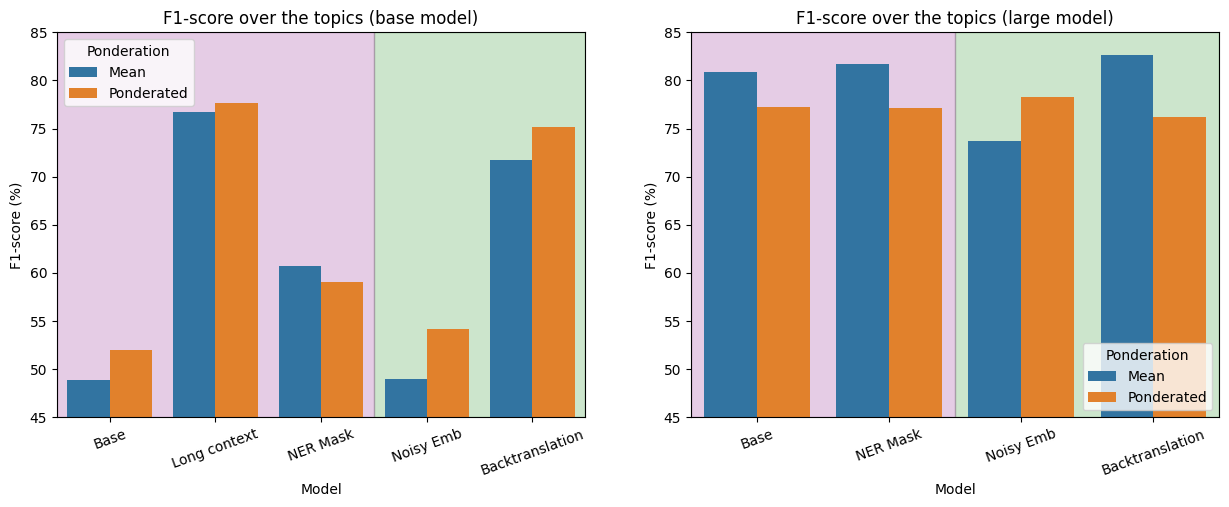

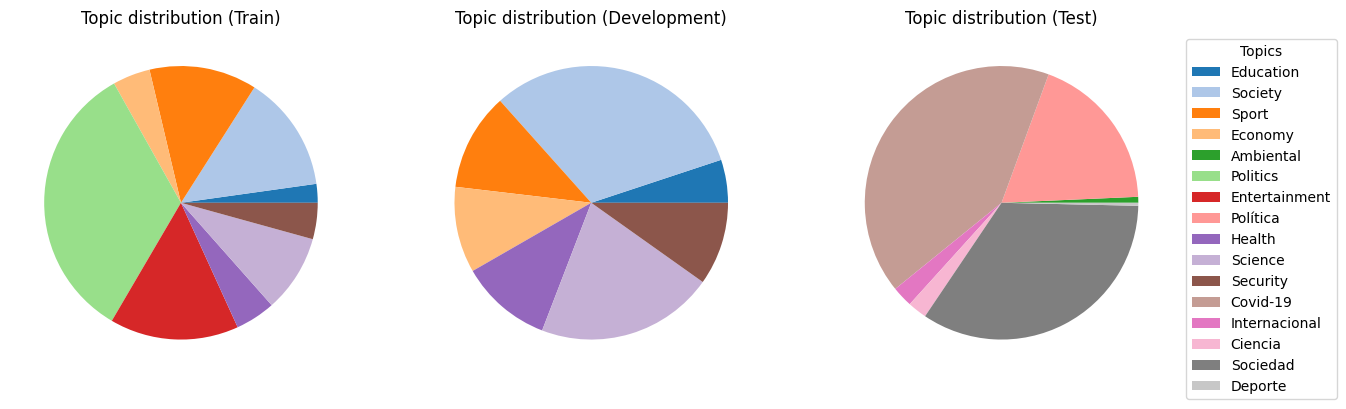

In [58]:
def get_scores(models, nombres):
    print('F1-score over the topics')
    print('\tMean\tPonderated')
    data = pd.DataFrame(columns=['Model', 'F1-score (%)', 'Ponderation'])
    for model, nombre in zip(models, nombres):
        scores = []
        for topic in model['topic'].unique():
            subset = model[model['topic'] == topic]
            scores.append(f1_score(subset['category'], subset['predictions'], average='macro'))
        mean = np.mean(scores)
        pond = f1_score(model["category"], model["predictions"], average="macro")
        data = pd.concat([data,pd.DataFrame({'Model': nombre, 'F1-score (%)': mean*100, 'Ponderation': 'Mean'}, index=[0])], ignore_index=True)
        data = pd.concat([data,pd.DataFrame({'Model': nombre, 'F1-score (%)': pond*100, 'Ponderation': 'Ponderated'}, index=[0])], ignore_index=True)
        print(f'{nombre}: {mean:.4f} | {pond:.4f}')
    print()
    return data
base_scores = get_scores([base,full_length,ner,noise,final],
                         ['Base', 'Long context', 'NER Mask', 'Noisy Emb', 'Backtranslation'])
large_scores = get_scores([base_large,ner_large,noise_large,final_large],
                            ['Base', 'NER Mask', 'Noisy Emb', 'Backtranslation'])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = plt.gca()
ax.axvspan(2.5, 4.5, color='green', alpha=0.2)
ax.axvspan(-0.5, 2.5, color='purple', alpha=0.2)

sns.barplot(x='Model', y='F1-score (%)', hue='Ponderation', data=base_scores)
ax.legend(loc='upper left', title='Ponderation')
plt.title('F1-score over the topics (base model)')
plt.xticks(rotation=20)
plt.ylim(45,85)

plt.subplot(1,2,2)
ax = plt.gca()
ax.axvspan(1.5, 3.5, color='green', alpha=0.2)
ax.axvspan(-0.5, 1.5, color='purple', alpha=0.2)

sns.barplot(x='Model', y='F1-score (%)', hue='Ponderation', data=large_scores)
ax.legend(loc='lower right', title='Ponderation')#, bbox_to_anchor=(1, 1))
plt.title('F1-score over the topics (large model)')
plt.xticks(rotation=20)
plt.ylim(45,85)

train = pd.read_json('../data/original/train.json')
dev = pd.read_json('../data/original/dev.json')
test = pd.read_json('../data/original/test.json')
topics = list(set(train['topic'].unique()) | set(dev['topic'].unique()) | set(test['topic'].unique()))

cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(len(topics))]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
#sns.countplot(x='topic',  data=full_length, stat='count')
counts = [len(train[train['topic'] == topic]) for topic in topics]
plt.pie(counts, colors=colors)
#plt.legend(train['topic'].unique(), title='Topics', loc='upper right', bbox_to_anchor=(1.5, 1))
plt.xticks(rotation=90)
plt.title('Topic distribution (Train)')

plt.subplot(1,3,2)
#sns.countplot(x='topic',  data=full_length, stat='count')
counts = [len(dev[train['topic'] == topic]) for topic in topics]
plt.pie(counts, colors=colors)
#plt.legend(train['topic'].unique(), title='Topics', loc='upper right', bbox_to_anchor=(1.5, 1))
plt.xticks(rotation=90)
plt.title('Topic distribution (Development)')

plt.subplot(1,3,3)
#sns.countplot(x='topic',  data=full_length, stat='count')
counts = [len(test[test['topic'] == topic]) for topic in topics]
plt.pie(counts, colors=colors)
plt.xticks(rotation=90)
plt.title('Topic distribution (Test)')
plt.legend(topics, title='Topics', loc='upper right', bbox_to_anchor=(1.5, 1))
#plt.legend(test['topic'].unique(), title='Topics', loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

## Confianza

In [43]:
from matplotlib.gridspec import GridSpec


def get_confidence_report(data, title, threshold=0.5):
    get_confidence = lambda pred: np.sqrt(np.mean(np.square(pred - threshold)))
    fig = plt.figure(figsize=(10,5))
    gs = GridSpec(2, 4, figure=fig)
    cm = np.zeros((2,2))

    fig.add_subplot(gs[0,0])
    subset = data[(data['category'] == 'Fake') & (data['predictions'] == 'Fake')]
    cm[0,0] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=20, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('Fake - Fake')

    fig.add_subplot(gs[0,1])
    subset = data[(data['category'] == 'Fake') & (data['predictions'] == 'True')]
    cm[0,1] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=10, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('Fake - True')

    fig.add_subplot(gs[1,0])
    subset = data[(data['category'] == 'True') & (data['predictions'] == 'Fake')]
    cm[1,0] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=5, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('True - Fake')

    fig.add_subplot(gs[1,1])
    subset = data[(data['category'] == 'True') & (data['predictions'] == 'True')]
    cm[1,1] = get_confidence(np.array(subset['prob_fake']))
    sns.histplot(subset['prob_fake'], bins=20, kde=True, stat='percent')
    plt.xlabel('Prob of Fake')
    plt.title('True - True')

    big_ax = fig.add_subplot(gs[:,2:])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LABELS.keys())
    disp.plot(ax=big_ax, colorbar=False)
    im = big_ax.imshow(cm, interpolation='nearest', cmap='viridis', vmin=0.20, vmax=0.5)
    big_ax.figure.colorbar(im, ax=big_ax)
    plt.title('Mean confidence')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


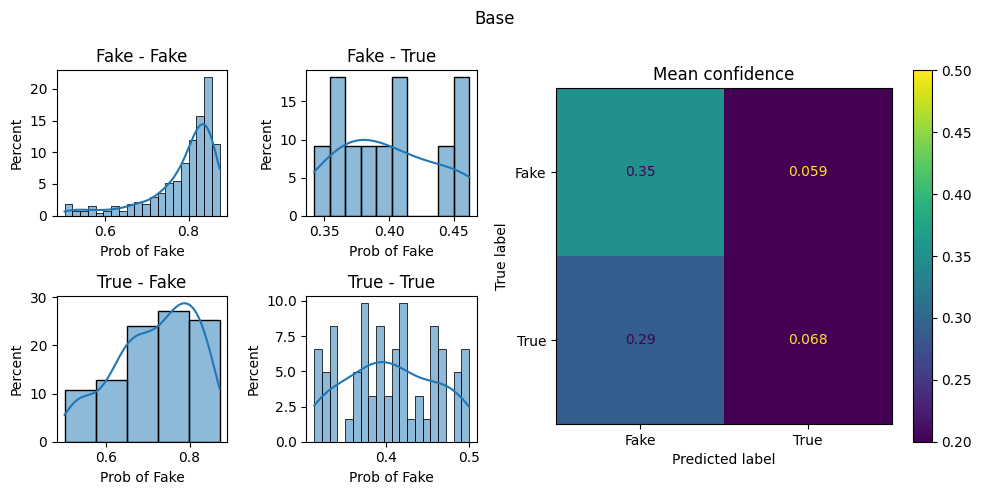

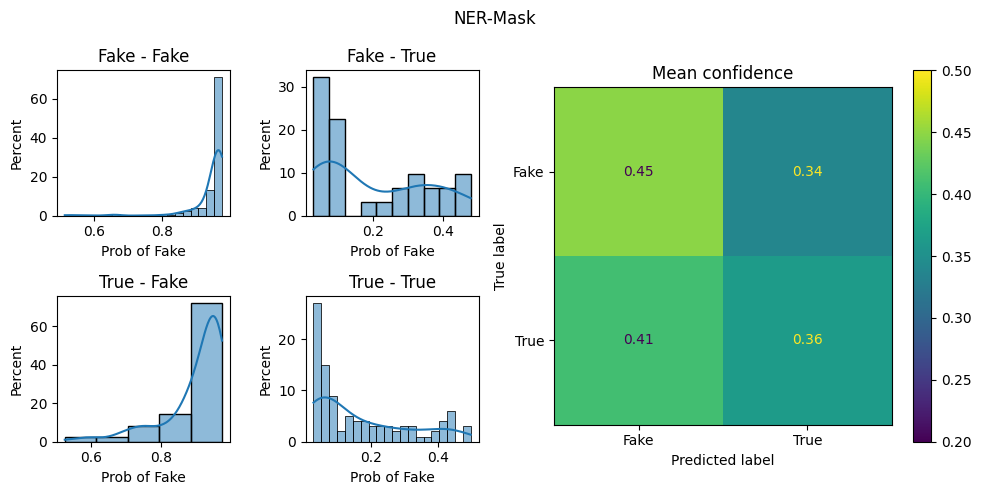

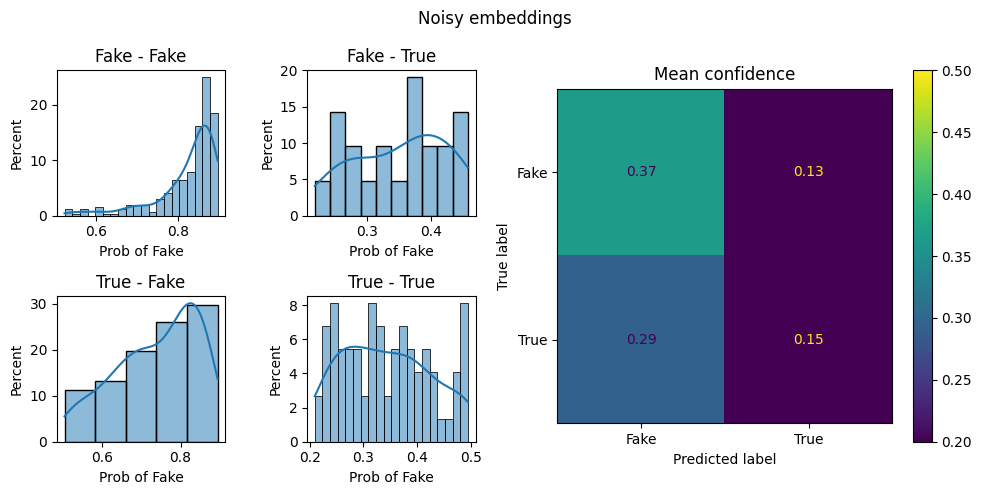

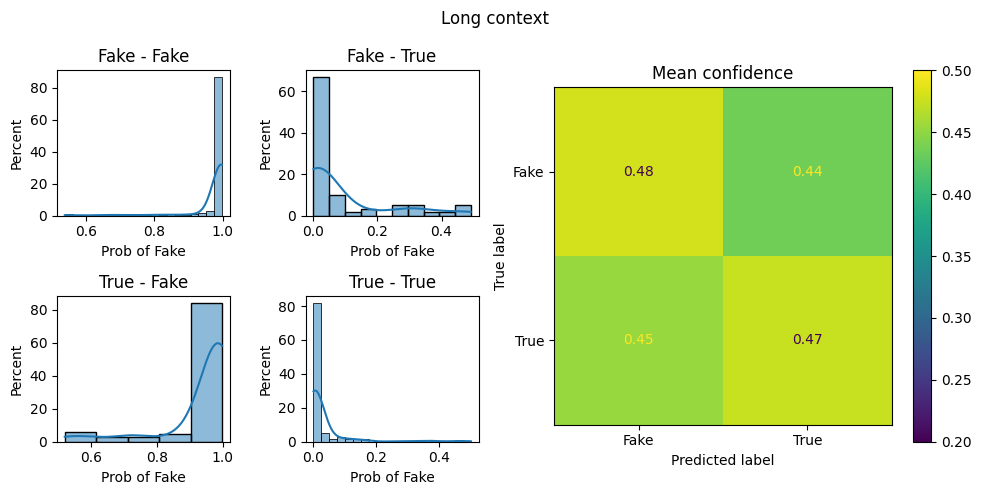

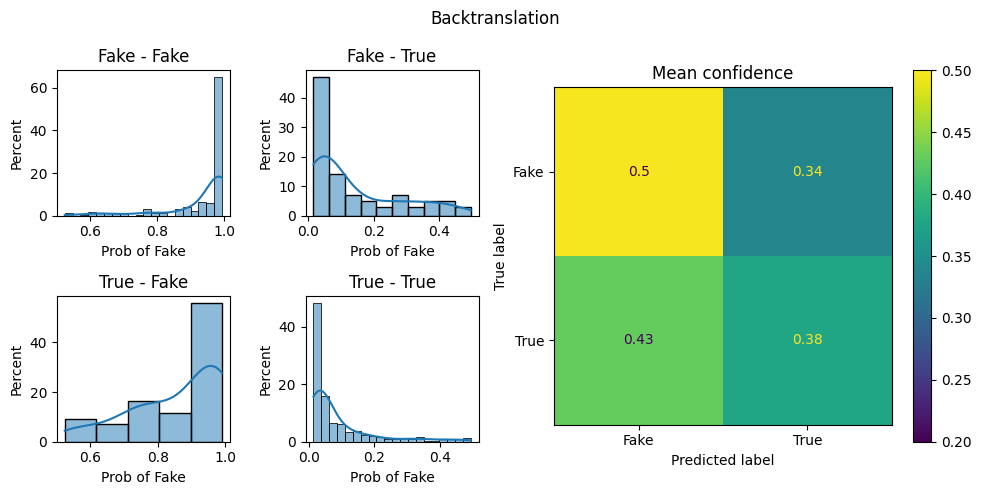

In [44]:
get_confidence_report(base, 'Base',threshold=0.44528159499168396)
get_confidence_report(ner, 'NER-Mask')
get_confidence_report(noise, 'Noisy embeddings',threshold=0.46455496549606323)
get_confidence_report(full_length, 'Long context')
get_confidence_report(final, 'Backtranslation', threshold=0.44906046986579895)

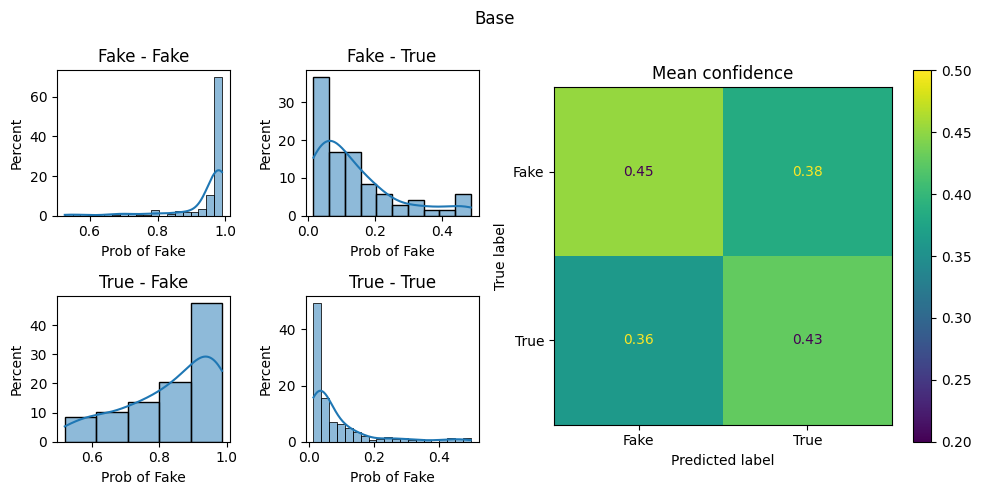

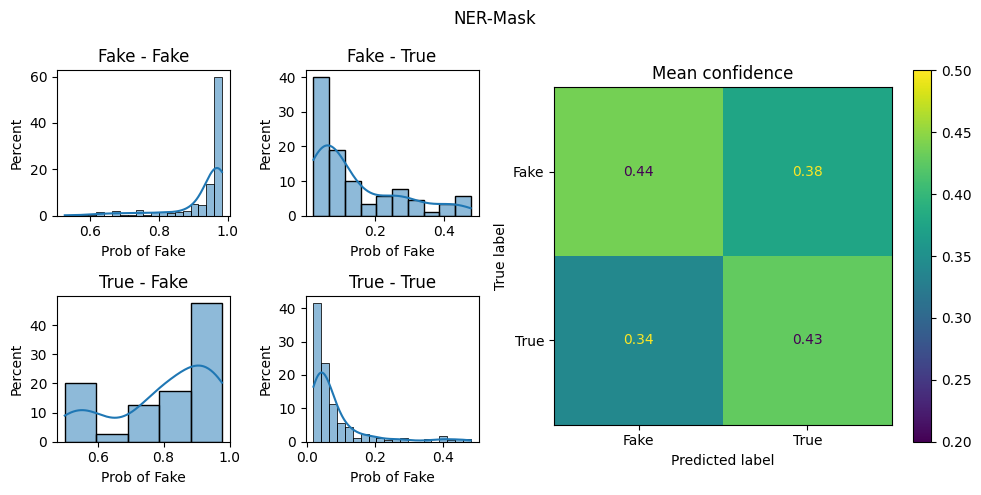

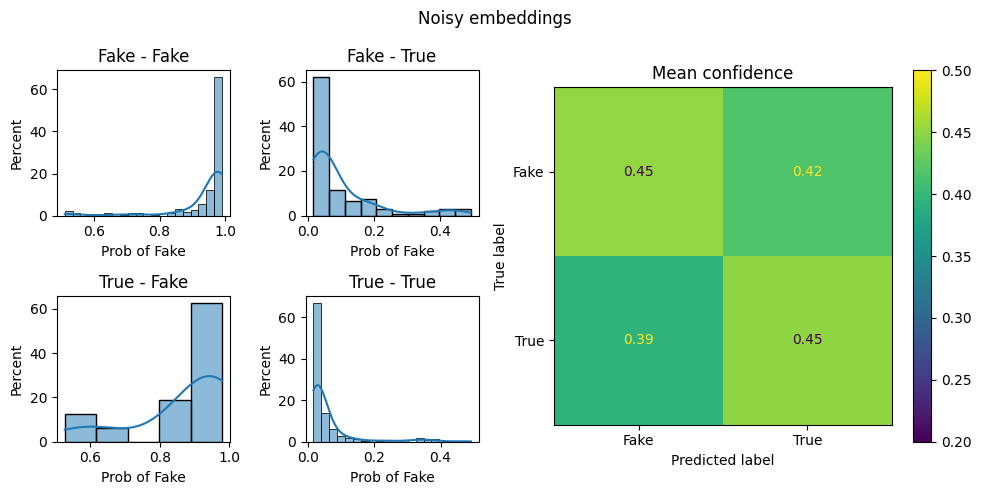

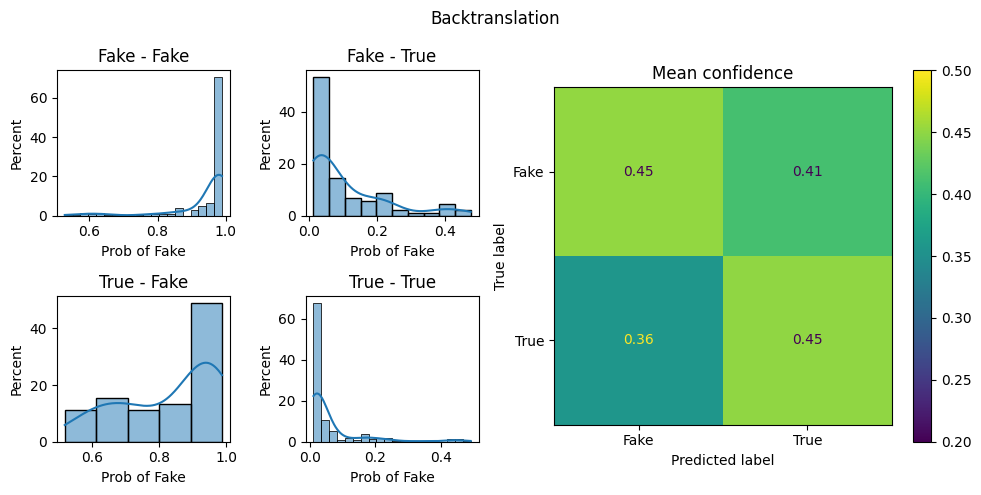

In [45]:
get_confidence_report(base_large, 'Base')
get_confidence_report(ner_large, 'NER-Mask')
get_confidence_report(noise_large, 'Noisy embeddings')
get_confidence_report(final_large, 'Backtranslation')

## Curva ROC

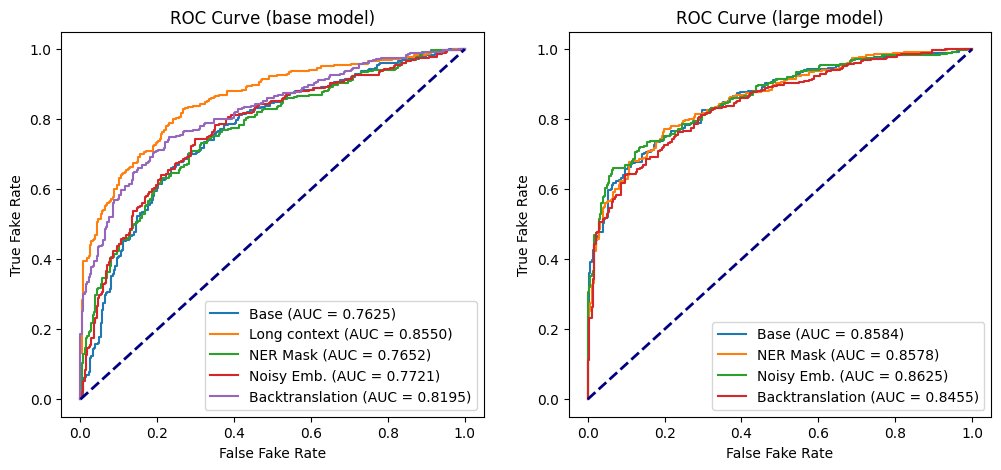

In [46]:
from sklearn.metrics import roc_curve, auc

def plot_roc(models, nombres):
    for model, nombre in zip(models, nombres):
        fpr, tpr, _ = roc_curve(model['category'], model['prob_fake'], pos_label='Fake')
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc(fpr, tpr):.4f})')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_roc([base, full_length, ner, noise, final],
         ['Base', 'Long context', 'NER Mask', 'Noisy Emb.', 'Backtranslation'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.xlabel('False Fake Rate')
plt.ylabel('True Fake Rate')
plt.title('ROC Curve (base model)')

plt.subplot(1,2,2)
plot_roc([base_large, ner_large, noise_large, final_large],
         ['Base', 'NER Mask', 'Noisy Emb.', 'Backtranslation'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.xlabel('False Fake Rate')
plt.ylabel('True Fake Rate')
plt.title('ROC Curve (large model)')
plt.show()

/tmp/ipykernel_17977/3707542931.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Topic': nombre, 'Model': topic, 'AUC': auc(fpr, tpr)}, index=[0])], ignore_index=True)
/tmp/ipykernel_17977/3707542931.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Topic': nombre, 'Model': topic, 'AUC': auc(fpr, tpr)}, index=[0])], ignore_index=True)


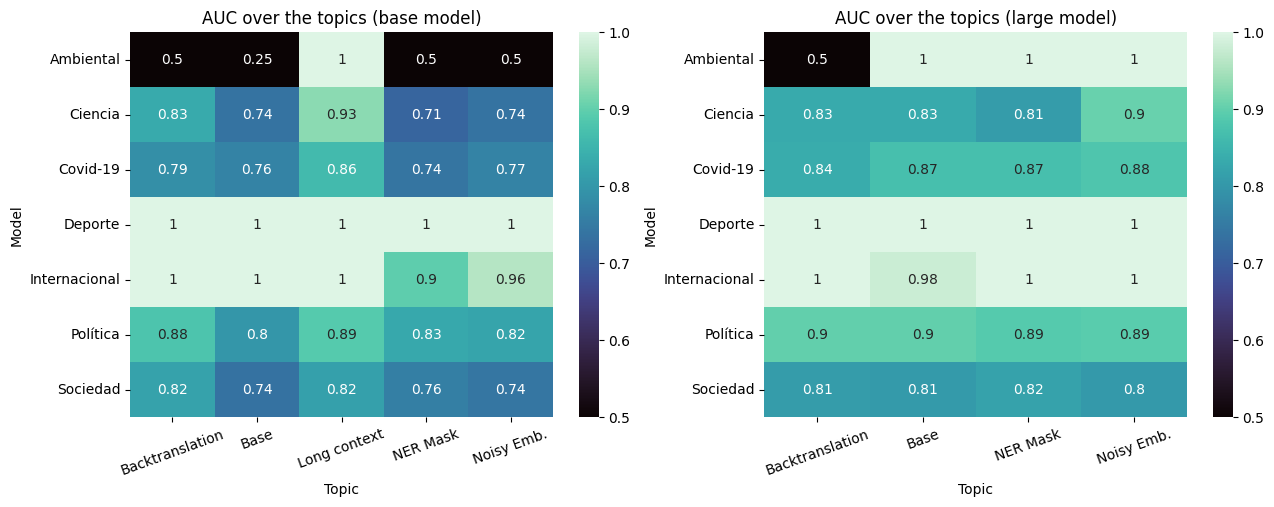

In [47]:
def get_auc(models, nombres):
    df = pd.DataFrame(columns=['Model', 'Topic', 'AUC'])
    for model, nombre in zip(models, nombres):
        for topic in model['topic'].unique():
            subset = model[model['topic'] == topic]
            fpr, tpr, _ = roc_curve(subset['category'], subset['prob_fake'], pos_label='Fake')
            df = pd.concat([df, pd.DataFrame({'Topic': nombre, 'Model': topic, 'AUC': auc(fpr, tpr)}, index=[0])], ignore_index=True)
    return df

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df = get_auc([base, full_length, ner, noise, final],
                ['Base', 'Long context', 'NER Mask', 'Noisy Emb.', 'Backtranslation'])
sns.heatmap(df.pivot(index='Model', columns='Topic', values='AUC'), annot=True, cmap='mako', vmin=0.5, vmax=1)
plt.title('AUC over the topics (base model)')
plt.xticks(rotation=20)

plt.subplot(1,2,2)
df = get_auc([base_large, ner_large, noise_large, final_large],
                ['Base', 'NER Mask', 'Noisy Emb.', 'Backtranslation'])
sns.heatmap(df.pivot(index='Model', columns='Topic', values='AUC'), annot=True, cmap='mako', vmin=0.5, vmax=1)
plt.title('AUC over the topics (large model)')
plt.xticks(rotation=20)
plt.show()